# Scaling collpase cleaned

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fssa import quality
from tqdm import tqdm
import numpy.ma as ma
import numpy as np
import seaborn as sns
from scipy.optimize import minimize

In [127]:
def load_IDs(L, seeds):
    Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

    ID = -1*np.ones((len(seeds),len(Ws)))
    R2 = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID'] for i in range(len(Ws))])
            R2[seed] = np.array([data[i]['rsquared'] for i in range(len(Ws))])
            
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    return ID, R2

def x_func(rho, rho_c, l, nu):
    return np.power(l, 1./nu) * (rho-rho_c)

def x_BKT(rho, rho_c, l, alpha):
    return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))

def y_func(y, l, zeta,nu):
    return np.power(l, -zeta/nu) * y

def goal_function(args = [3.,2.2,1.2, 1.4], x_bounds=[0,7]):
    ''' rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]'''
    rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]
    
    x,y,dy = scaledata(l,rho,a,da,rho_c,nu,zeta, alpha)
    return quality(x,y,dy)
    
def scaledata(l, rho, a, da, rho_c, nu, zeta, alpha):
    # rho_c, nu, and zeta should be float
    rho_c = float(rho_c)
    nu = float(nu)
    zeta = float(zeta)   

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    
    '''x = np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c) ## old'''
    x = x_BKT(rho_mesh, rho_c,l_mesh,alpha)
    y = np.power(l_mesh, - zeta / nu) * a
    dy = np.power(l_mesh, - zeta / nu) * da

    sorting_index = np.argsort(x)[0]
    
    x = x[:,sorting_index]
    y = y[:,sorting_index]
    dy = dy[:, sorting_index]

    return x, y, dy

def autoscale(l, rho, a, da, rho_c0, nu0, zeta0, alpha0, x_bounds=None, **kwargs):
    def goal_function(args = [3.,2.2,1.2, 1.4]):
        ''' rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]'''
        rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]

        x,y,dy = scaledata(l,rho,a,da,rho_c,nu,zeta, alpha)
        return quality(x,y,dy, x_bounds=x_bounds)
    

    ret = minimize(
        goal_function,
        [rho_c0, nu0, zeta0,alpha0],
        method='Nelder-Mead',
        options={
            'xtol': 1e-2,
            'ftol': 1e-2,
        }
    )

    errors, varco = _neldermead_errors(
        sim=ret['final_simplex'][0],
        fsim=ret['final_simplex'][1],
        fun=goal_function,
    )

    ret['varco'] = varco
    ret['errors'] = errors
    ret['rho'], ret['nu'], ret['zeta'], ret['alpha'] = ret['x']
    ret['drho'], ret['dnu'], ret['dzeta'], ret['dalpha'] = ret['errors']

    return ret
def _neldermead_errors(sim, fsim, fun):
    """
    Estimate the errors from the final simplex of the Nelder--Mead algorithm
    This is a helper function and not supposed to be called directly.
    Parameters
    ----------
    sim : ndarray
        the final simplex
    fsim : ndarray
        the function values at the vertices of the final simplex
    fun : callable
        the goal function to minimize
    """

    # fit quadratic coefficients
    n = len(sim) - 1

    ymin = fsim[0]

    sim = np.copy(sim)
    fsim = np.copy(fsim)

    centroid = np.mean(sim, axis=0)
    fcentroid = fun(centroid)

    # enlarge distance of simplex vertices from centroid until all have at
    # least an absolute function value distance of 0.1
    for i in range(n + 1):
        while np.abs(fsim[i] - fcentroid) < 0.01:
            sim[i] += sim[i] - centroid
            fsim[i] = fun(sim[i])

    # the vertices and the midpoints x_ij
    x = 0.5 * (
        sim[np.mgrid[0:n + 1, 0:n + 1]][1] +
        sim[np.mgrid[0:n + 1, 0:n + 1]][0]
    )

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(x[i, j])

    y0i = y[np.mgrid[0:n + 1, 0:n + 1]][0][1:, 1:, 0]

    y0j = y[np.mgrid[0:n + 1, 0:n + 1]][0][0, 1:, 1:]

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)

    q = (sim - sim[0])[1:].T

    varco = ymin * np.dot(q, np.dot(np.linalg.inv(b), q.T))
    return np.sqrt(np.diag(varco)), varco

In [101]:
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

ID8, R2_8 = load_IDs(8, range(0,100000))
ID10, R2_10 = load_IDs(10, range(0,10000))
ID12, R2_12 = load_IDs(12, range(0,5000))
ID14, R2_14 = load_IDs(14, range(0,1000))

Loaded 100000 out of 100000 seeds
Loaded 10000 out of 10000 seeds
Loaded 5000 out of 5000 seeds
Loaded 1000 out of 1000 seeds


In [102]:
l = [8,10,12,14]
rho = Ws
a = np.vstack([ma.average(ID, axis=0, weights=R2) for ID, R2 in zip([ID8,ID10,ID12,ID14],
                                                                   [R2_8,R2_10,R2_12,R2_14])])

da = np.vstack([np.array([np.sqrt(np.cov(ID14[:,W], 
                aweights=R2_14[:,W])) for W in range(len(Ws))]) for ID, R2 in zip([ID8,ID10,ID12,ID14],
                                                                   [R2_8,R2_10,R2_12,R2_14])])

start,stop = 8,47
a_full, da_full, rho_full = a.copy(), da.copy(), rho.copy()
a, da, rho = a[:,start:stop],da[:,start:stop],rho[start:stop]
rho

array([2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 ,
       3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65,
       3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 ,
       4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ])

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-99-9676486652d2>:27: RuntimeWarning: divide by zero encountered in true_divide
  return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))
100%|██████████| 100/100 [00:01<00:00, 52.70it/s]


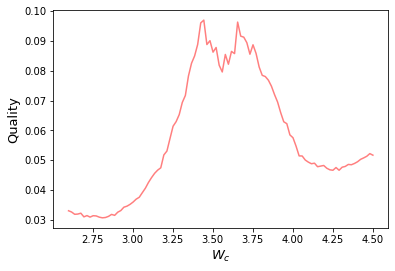

In [103]:
out = []
rs = np.linspace(min(rho),max(rho),100)
for r in tqdm(rs):
    out.append(goal_function([r,1.65,2.17,1.53]))
plt.plot(rs,out, c='r', alpha=.5)
plt.xlabel('$W_c$', fontsize=13)
plt.ylabel('Quality', fontsize=13)
plt.show()

In [128]:
ret = autoscale(l, rho, a, da, 3.66,1.8,1.94, 1.40)#, x_bounds=(3.2,3.8))
ret

<ipython-input-127-cf3e25935221>:144: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(varco)), varco


         alpha: 1.3763701573127023
        dalpha: nan
           dnu: 0.6187883502567226
          drho: nan
         dzeta: 0.9501576897467217
        errors: array([       nan, 0.61878835, 0.95015769,        nan])
 final_simplex: (array([[4.40074672, 1.68201904, 1.78754801, 1.37637016],
       [4.40081443, 1.68061356, 1.78955791, 1.37367357],
       [4.40095211, 1.68193352, 1.79107517, 1.37324953],
       [4.39525234, 1.68352653, 1.78985184, 1.37681489],
       [4.39929507, 1.682057  , 1.7900102 , 1.3736785 ]]), array([0.02767918, 0.02771841, 0.02772043, 0.02853994, 0.02875122]))
           fun: 0.02767918494437247
       message: 'Optimization terminated successfully.'
          nfev: 61
           nit: 27
            nu: 1.6820190373861998
           rho: 4.400746717953696
        status: 0
       success: True
         varco: array([[ -1.78387531,  -1.20054657,  -1.16514631,  -5.00875532],
       [ -1.20054657,   0.38289902,   0.54298738,  -2.56099943],
       [ -1.16514631,   0.

In [105]:
x, y, dy = scaledata(l, rho, a, da, ret['rho'], ret['nu'], ret['zeta'], ret['alpha'])

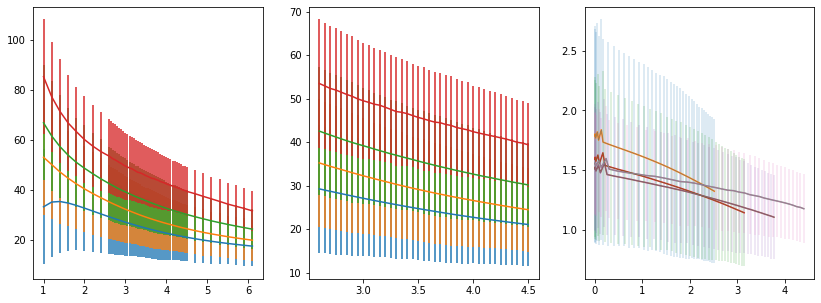

In [106]:
fig, ax = plt.subplots(1,3, figsize=(14,5))

for i,j,k in zip(np.vstack([rho_full,rho_full,rho_full,rho_full]),a_full,da_full):
    ax[0].errorbar(i,j, yerr=k)    

for i,j,k in zip(np.vstack([rho,rho,rho,rho]),a,da):
    ax[1].errorbar(i,j, yerr=k)    

for i,j,k in zip(x,y,dy):
    ax[2].errorbar(i,j, yerr=k, lw=.3)
    ax[2].plot(i,j)
#ax[1].set_xlim(0,100)